In [1]:
import pandas as pd
from util import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import data_cleaning
from data_cleaning import *
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from yellowbrick.model_selection import FeatureImportances

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", None)
pd.set_option("precision", 3)
sns.set_context("talk") # talk context is good for RISE presentations
# matplotlib.style.use('default')
%pylab inline
%config InlineBackend.figure_formats = ['retina']


Populating the interactive namespace from numpy and matplotlib


## **1. Load datasets**

### 1.1 Whole data frame

In [3]:
q = """
SELECT * from ma_refinance_new
"""
df = do(q)
df.head(3)


,derived_msa_md,county_code,conforming_loan_limit,derived_loan_product_type,derived_race,derived_sex,lien_status,open_end_line_of_credit,business_or_commercial_purpose,hoepa_status,interest_only_payment,balloon_payment,occupancy_type,total_units,applicant_race_1,applicant_sex,applicant_age_above_62,co_applicant_age_above_62,loan_term,loan_amount,property_value,loan_to_value_ratio,income,debt_to_income_ratio,total_age,applicant_age,co_applicant_age,action_taken,denial_reason_1,denial_reason_2,denial_reason_3,denial_reason_4
0,15764,25017,C,First,White,Male,1,2,2,2,2,2,1,1,White,1,No,N/A,180,"265,000.00",815000,32.10,114.00,33,40,40,0,1,10,nan,nan,nan
1,15764,25009,C,First,Race Not Available,Male,1,2,1,3,2,2,3,2,No info.,1,No,N/A,300,"265,000.00",525000,50.29,89.00,25,30,30,0,1,10,nan,nan,nan
2,15764,25017,C,First,White,Male,1,2,2,2,2,2,1,1,White,1,No,N/A,360,"305,000.00",575000,52.27,75.00,45,40,40,0,1,10,nan,nan,nan


### 1.2 Split into training and testing datasets

In [4]:
fn = '../data/data_vf.pickle'
data_dict = read_from_pickle(fn)
x_train = data_dict['x_train']
y_train = data_dict['y_train']
x_val = data_dict['x_val']
y_val = data_dict['y_val']
#-------------------------------------------------------------------------
x_train = pd.concat([x_train, x_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)
#-------------------------------------------------------------------------
x_test = data_dict['x_test']
y_test = data_dict['y_test']
#-------------------------------------------------------------------------

Read data from "../data/data_vf.pickle"


In [5]:
fn = ("../data/idx_sel_feat_permu_importance.pickle")
idx_sel_feat = read_from_pickle(fn)

Read data from "../data/idx_sel_feat_permu_importance.pickle"


## **2. Feature selection based on a random forest classifier**
### 2.1 Run "feature_selection.ipynb" to identify best parameters using random forest classifier  

Selected features can be identified using the index "id_sel_feat". They are sorted by Gini importance.

### 2.2 Use the entire training and testing datasets to score the model

Read the pipeline to get the tuned random forest model

In [6]:
fn = '../data/rf_pipeline.pickle'
pipe_rf_randcv = read_from_pickle(fn)

Read data from "../data/rf_pipeline.pickle"


In [7]:
# Make a pipeline and fit a random forest model
x_train_new = x_train.iloc[:,idx_sel_feat]
x_test_new = x_test.iloc[:,idx_sel_feat]

categorical_columns = ['hoepa_status', 'occupancy_type',
                       'business_or_commercial_purpose','open_end_line_of_credit',
                       'derived_loan_product_type', 'lien_status'
                      ]
numerical_columns = ['debt_to_income_ratio']

mdl_rf_rand = pipe_rf_randcv.best_estimator_.named_steps['classifier']
mdl_rf_rand.n_jobs=-1

pipe_mdl_rf = make_mdl_eval_pipeline(mdl_rf_rand,
                       categorical_columns,
                       numerical_columns,
                      )

pipe_mdl_rf.fit(x_train_new, y_train);
mdl_rf = pipe_mdl_rf.named_steps['classifier']

In [8]:
# Print performance metrics
x_test_new_tform = pipe_mdl_rf.named_steps['preprocess'].transform(x_test_new)
y_pred = mdl_rf.predict(x_test_new_tform)
y_score = mdl_rf.predict_proba(x_test_new_tform)
metrics_rf = multi_metrics(y_test, y_pred, y_score)
print_metrics(metrics_rf)

roc_auc = 0.99 
accuracy = 0.97 
precision = 0.99 
recall = 0.97 
f1 = 0.98


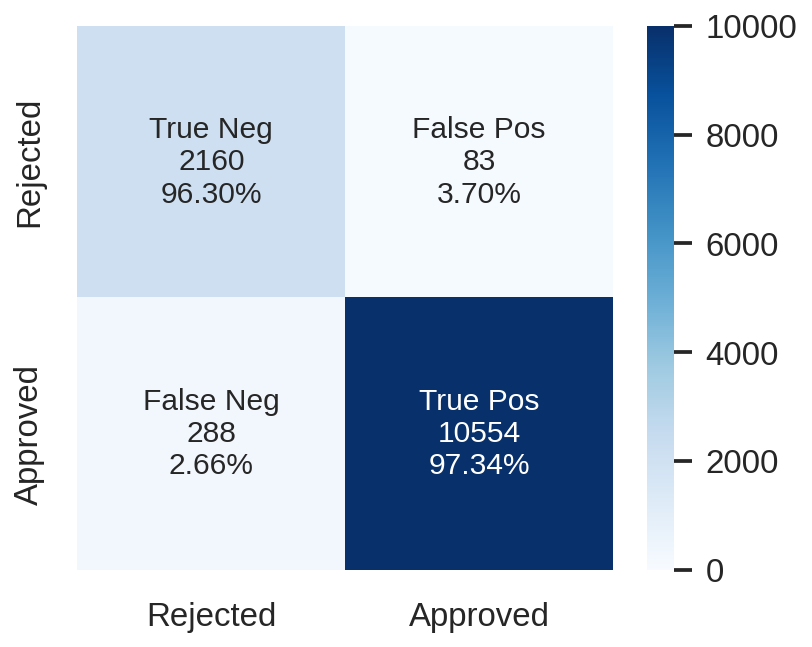

In [9]:
# plot confusion matrix
cf_mat_rf = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(6, 5))
ax = disp_confusion_matrix(cf_mat_rf, vmin=0, vmax=10000)
ax.tick_params(left=False, bottom=False)
tick_labels = ['Rejected', 'Approved']
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels, va='center')

plt.savefig("../figures/cf_mat_rf.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

## **3. Comparison with other tuned models based on 5-fold cross-validation**

### 3.1. Logistic ergression
Tune a logistic regression model based on the area under the ROC from varying L2 penalty strength i.e. [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [10]:
random_grid = {'classifier__C':[0.0, 0.0001, 0.001, 0.01, 0.1, 1.0], }
base_mdl = LogisticRegression(solver='newton-cg',
                              penalty='l2',
                              n_jobs=-1)
pipe_logreg = make_cv_pipelinie(base_mdl,
                                categorical_columns,
                                numerical_columns,
                                random_grid,
                                scoring='roc_auc'
                               )
pipe_logreg.fit(x_train_new, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


In [11]:
# Fit logistric regression model
mdl_logreg = pipe_logreg.best_estimator_.named_steps['classifier']
mdl_logreg.n_jobs=-1

pipe_mdl_logreg = make_mdl_eval_pipeline(mdl_logreg,
                                         categorical_columns,
                                         numerical_columns,
                                        )
pipe_mdl_logreg.fit(x_train_new, y_train);

In [12]:
# print performance
y_pred = mdl_logreg.predict(x_test_new_tform)
y_score = mdl_logreg.predict_proba(x_test_new_tform)
metrics_logreg = multi_metrics(y_test, y_pred, y_score)
print_metrics(metrics_logreg)

roc_auc = 0.99 
accuracy = 0.97 
precision = 0.99 
recall = 0.97 
f1 = 0.98


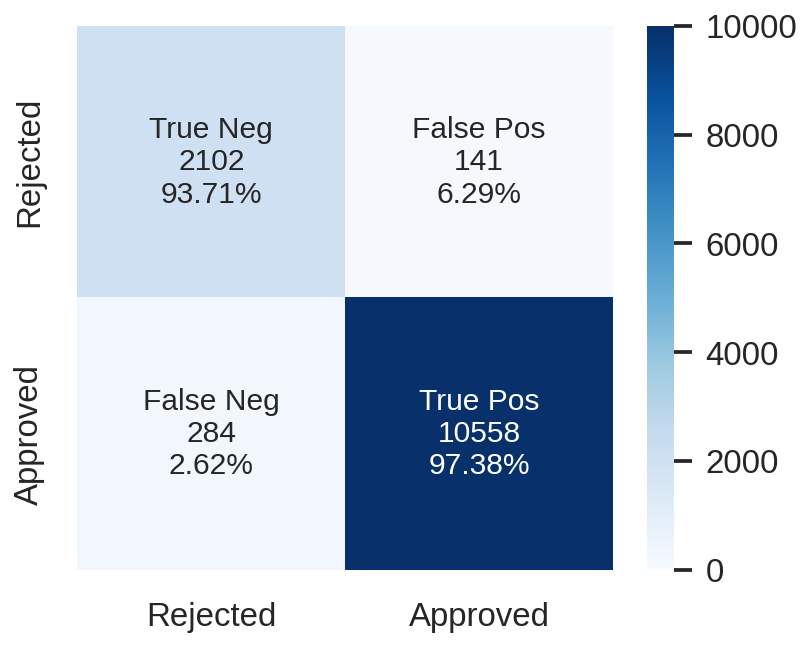

In [13]:
# plot confusion matrix
cf_mat_logreg = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(6, 5))
ax = disp_confusion_matrix(cf_mat_logreg, vmin=0, vmax=10000)
ax.tick_params(left=False, bottom=False)
tick_labels = ['Rejected', 'Approved']
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels, va='center')

plt.savefig("../figures/cf_mat_logreg.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

#### 3.1.1 Feature importance from logistic regression
While we know the important features identified from random forest model that are typically used by lenders to make decisions, we still do not know how the feature categories affect decision making. Therefore, a logistic regressoin model was used for a better interpretability. 

In [14]:
feat_importance_logreg_sorted, visualizer = get_feat_importance_logreg(mdl_logreg,
                                                           x_test_new_tform,
                                                           y_test)
idx_sorted = visualizer.features_

feat_name = (pipe_mdl_logreg.
             named_steps['preprocess'].
             named_transformers_['cat'].
             get_feature_names(input_features=categorical_columns))
feat_name = np.append(feat_name, 'debt_to_income_ratio')
feat_name = np.append(feat_name, 'load_to_property_ratio')
feat_name_sorted = feat_name[idx_sorted]

<Figure size 432x288 with 0 Axes>

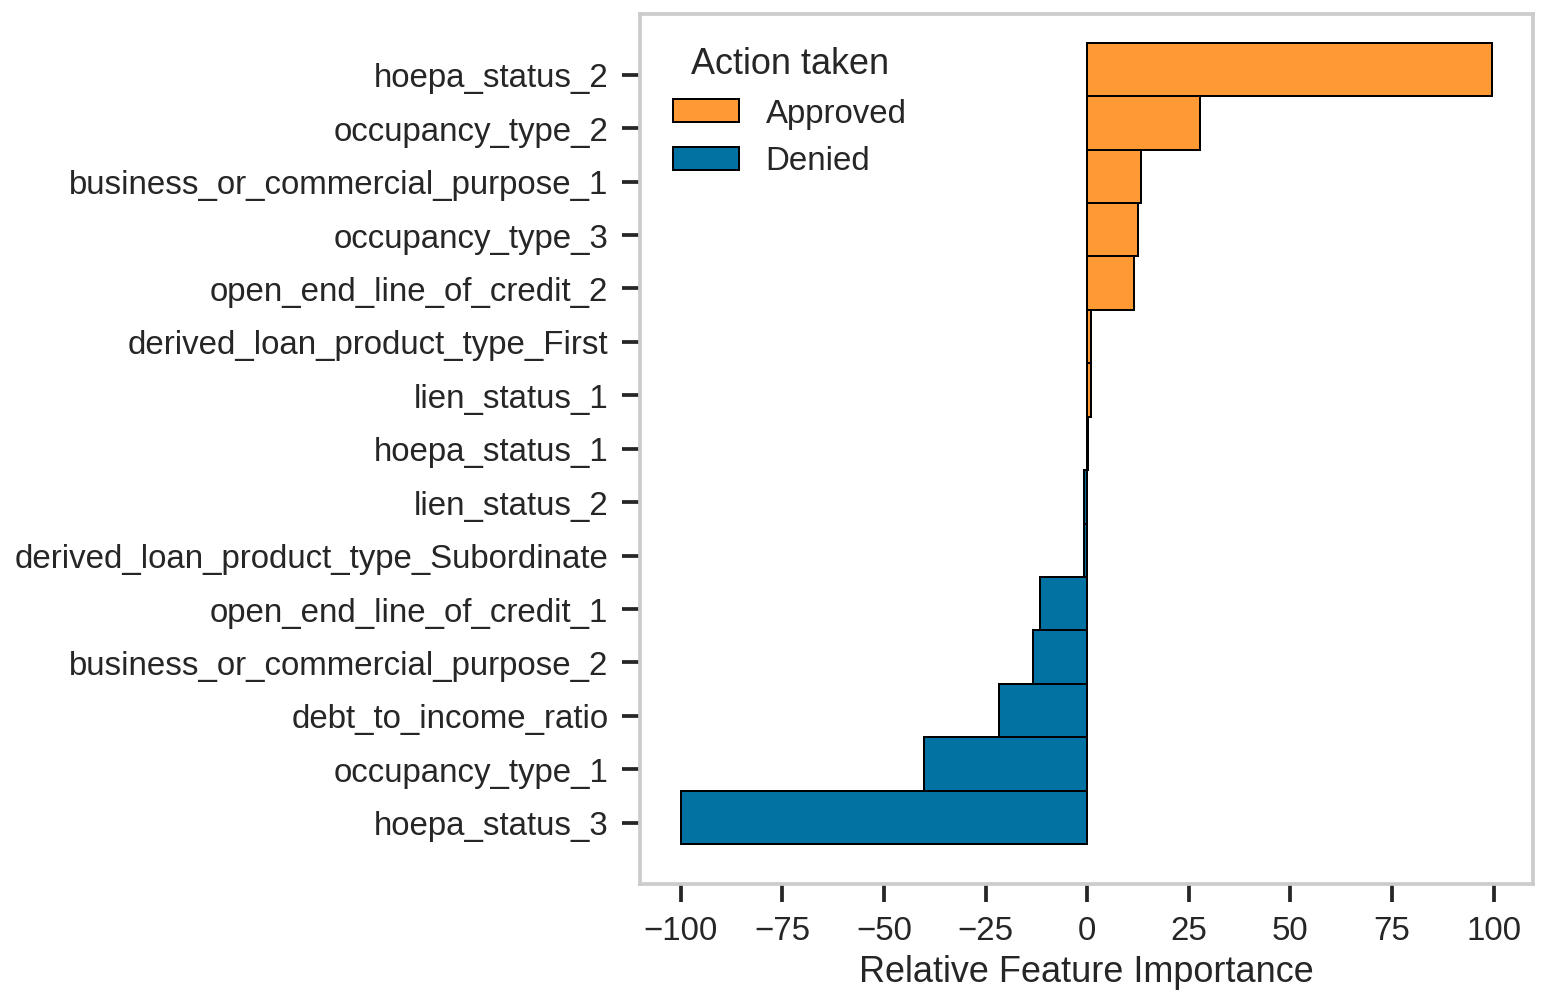

In [15]:
df_plt = pd.DataFrame(feat_importance_logreg_sorted,
                      columns=['Feature importances'])
df_plt.index = feat_name_sorted

plt.subplots(figsize=(8, 8))
ax = plt.barh(feat_name_sorted,
              df_plt['Feature importances'][::-1],
              edgecolor=(0,0,0),
              lw=1,
             )

[t_ax.set_height(1) for t_ax in ax.patches];
[t_ax.set_facecolor([255/255, 153/255, 51/255])
 for t_ax in ax.patches[-8:]]

plt.grid(False)

plt.legend(ax.patches[10:0:-9],
           ('Approved', 'Denied'),
          title='Action taken',
          framealpha=1, shadow=True, borderpad=0.5
          );
plt.xlabel('Relative Feature Importance');
plt.savefig("../figures/rel_feat_importance_logreg.svg",
            dpi=300, bbox_inches='tight', facecolor="white")